In [1]:
import pandas as pd
from ipywidgets import Video
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from scipy import signal as sig
import matplotlib.mlab as mlab

In [2]:
CSV_PATH = f'test.csv'
DATA_FOLDER = f'test_dataset'  #путь к видео
EMBED_PATH = f'embeddings'      #путь, где сохранить эмбеддинги видео
AUDIO_EMBED_PATH = f'audio'     #путь, где сохранить эмбеддинги звука
HEIGHT = 320                    #высота, до которой сжать
WIDTH = 180                     #ширина, до которой сжать

VOTE_MAXDIFF = 5                #максимальное различие в сдвиге видео (в кадрах), при котором допустим консенсус
CROP = 0.1                      #какую часть видео в начале и конце обрезать

VID_TRESHOLD = 0.1              #Похожесть, при которой видео считаются априори одинаковыми
VID_SOUND_TRESHOLD = 0.2        #Похожесть, при которой видео считаются одинаковыми, если совпадёт звук

df = pd.read_csv(CSV_PATH)

df.head(10)

,created,uuid,link
0,2024-06-01 01:37:57,49577a11-51b9-490a-b1f0-df17335219de,https://s3.ritm.media/yappy-db-duplicates/4957...
1,2024-06-01 04:42:10,4e1f7fad-5008-4216-9849-550a00f1e35f,https://s3.ritm.media/yappy-db-duplicates/4e1f...
2,2024-06-01 08:44:48,337fdbe6-2bc7-4bc7-931e-d94ada927ede,https://s3.ritm.media/yappy-db-duplicates/337f...
3,2024-06-01 10:11:48,35138a88-0249-405e-91b4-8a36b1e2e730,https://s3.ritm.media/yappy-db-duplicates/3513...
4,2024-06-01 12:23:29,322f4312-3d46-401b-8cd9-80a0d06347ed,https://s3.ritm.media/yappy-db-duplicates/322f...
5,2024-06-01 13:17:58,154ef8f1-b0ce-49cb-b5b1-34d8f975875d,https://s3.ritm.media/yappy-db-duplicates/154e...
6,2024-06-01 18:00:02,1c529118-dd4f-4c2d-a01a-1c5bf363ee4b,https://s3.ritm.media/yappy-db-duplicates/1c52...
7,2024-06-01 18:09:34,22d891cc-563a-48c9-9b6e-368829598e91,https://s3.ritm.media/yappy-db-duplicates/22d8...
8,2024-06-01 19:50:10,22ee80a3-d9ef-48d4-83d7-9c97cc7030c2,https://s3.ritm.media/yappy-db-duplicates/22ee...
9,2024-06-01 19:50:44,036cb3a9-4505-43e1-a781-b58534bfecce,https://s3.ritm.media/yappy-db-duplicates/036c...


In [3]:
file_names = os.listdir(DATA_FOLDER)#фильтрация загруженных видео

uuids_from_downloaded_videos = [os.path.splitext(file)[0] for file in file_names]
df_mini = df[df['uuid'].isin(uuids_from_downloaded_videos)]

In [4]:
df_mini.shape

(1000, 3)

In [5]:
def load(file):
    """
    Загрузка видеофайла
    """
    vid = cv2.VideoCapture(file)
    
    frames = np.zeros((int(vid.get(cv2.CAP_PROP_FRAME_COUNT)), HEIGHT, WIDTH, 3), dtype=np.uint8)
    i = 0
    while (True):
        success, frame = vid.read()
        if success:
            frames[i] = cv2.resize(frame, (WIDTH, HEIGHT))
        else:
            break
        i+=1
    return frames

vid0 = load("video/35f885ff-aefa-4de4-b2ee-11ab13bb71b2.mp4")

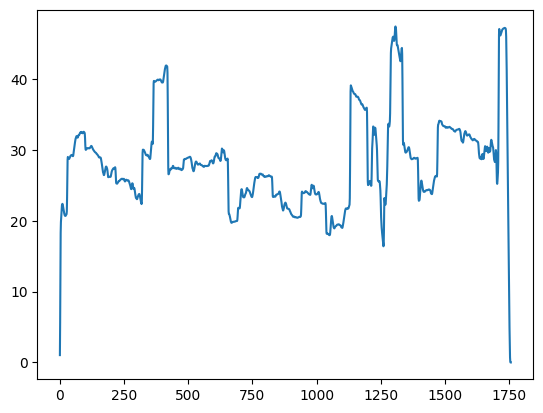

In [6]:
def static_mask(frames):
    """
    Возвращает маску, фильтрующую статичные писклеи на видео
    """
    kmax, kmin = int(frames.shape[0]*(1-CROP)), int(frames.shape[0]*CROP)
    diff = (np.max(frames[kmin:kmax], axis=0) - np.min(frames[kmin:kmax], axis=0)).sum(axis=2)
    return np.less(diff, 5)

def gkern(l=5, sig=1.):
    """
    Ядро Гаусса (сглаживание)
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    return gauss / np.sum(gauss)

def get_bright(frames):
    """
    Вычисляет среднее значение яркости кадров, и возвращает сглаженную последовательность
    """
    mask = static_mask(frames)
    frames[:, mask, :] = 0
    res = np.dot(np.sum(np.sum(frames, axis=1), axis=1)/(frames.shape[1]*frames.shape[2]-mask.sum()), np.array([0.299, 0.587, 0.114]))
    return np.convolve(res, gkern())


plt.plot(get_bright(vid0))

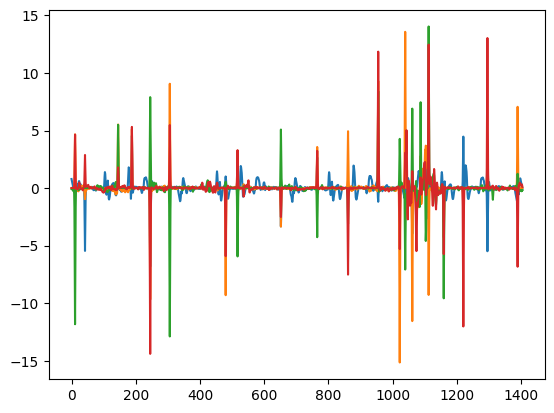

In [7]:
def get_embed(frames):
    """
    Возвращает эмбеддинг видео - производные яркости по времени по четвертям экрана
    """
    q = []
    q.append(frames[:, :HEIGHT//2, :WIDTH//2, :])
    q.append(frames[:, :HEIGHT//2, WIDTH//2:, :])
    q.append(frames[:, HEIGHT//2:, :WIDTH//2, :])
    q.append(frames[:, HEIGHT//2:, WIDTH//2:, :])
    res = []
    for i in range(4):
        bright = get_bright(q[i])
        diff = bright[1:] - bright[:-1]
        res.append(diff[int(len(diff)*CROP):int(len(diff)*(1-CROP))])
    return np.array(res)

emb0 = get_embed(vid0)
for i in range(4):
    plt.plot(emb0[i])
plt.show()

In [8]:
def get_shift(embed1, embed2):
    """
    Возвращает сдвиг, на который нужно сдвинуть эмбеддинг 2, чтобы совпасть с эмбеддингом 1
    """
    res = np.zeros(4)
    for i in range(4):
        e12 = embed1[i]*embed1[i]
        conv = np.convolve(embed1[i], np.flip(embed2[i]), mode='valid')/np.sqrt(np.convolve(e12, np.ones(embed2[i].shape[0]), mode='valid'))
        res[i] = np.argmax(conv)
    return res

In [9]:
def vote(shift):
    """
    Голосование за значение, требуется хотя бы 3 голоса за близкие на VOTE_MAXDIFF значения
    """
    if shift.max()-shift.min()<=VOTE_MAXDIFF:
        return int(shift.mean())
    for i in range(shift.shape[0]):
        other = shift[np.arange(shift.shape[0])!=i]
        if other.max()-other.min()<=VOTE_MAXDIFF:
            return int(other.mean())
    return -1

In [10]:
def similarity_score(sample, base):
    """
    Возвращает число, кореллирующее с тем, насколько различны эмбеддинги (0 при одинаковых, inf при совсем различных)

    Сравниваются эмбеддинги четвертей экрана, и голосуют за сдвиг по времени, затем считается MAE
    """
    base1 = np.copy(base)
    if len(base1[0])<len(sample[0])-10:
        return np.inf
    if len(base1[0])<len(sample[0]):
        base = np.concatenate((base1, np.zeros((4, len(sample[0])-len(base1[0])))), axis=1)
    sample_norm = (sample-np.mean(sample, axis=1, keepdims=True))/np.std(sample, axis=1, keepdims=True)
    shift = vote(get_shift(base1, sample))
    if shift==-1:
        return np.inf

    shifted = base1[:, shift:shift+len(sample[0])]

    shifted_norm = (shifted-np.mean(shifted, axis=1, keepdims=True))/np.std(shifted, axis=1, keepdims=True)
    res = np.abs(shifted_norm - sample_norm).mean(axis=1)
    return (res.sum() - res.min() - res.max())/2

def similarity_scores(sample, data):
    order = data.keys()
    scores = dict()
    for key in order:
        scores[key] = similarity_score(sample, data[key])
    return scores

In [25]:
from tqdm.notebook import tqdm

def build_embeddings():
    """
    Сохраняет эмбеддинги всех видео в файлы
    """
    done = dict()
    for vid in os.listdir(EMBED_PATH):
        done[vid[:-4]] = True
    
    for filename in tqdm(os.listdir(DATA_FOLDER)):
        if filename==".DS_Store":
            continue
        id = filename[:-4]
        if id in done:
            continue
        vid = load(DATA_FOLDER+"/"+id+".mp4")
        
        embed = get_embed(vid)
        np.save(EMBED_PATH+"/"+id, embed)

In [26]:
DEFAULT_FS = 44100
DEFAULT_WINDOW_SIZE = 4096 * 4
DEFAULT_OVERLAP_RATIO = 0.5
DEFAULT_MAX_FREQ = 400 
PEAK_RATIO = 0.85
DERIVATIVE_TAILS = 0.05
DERIVATIVE_RATIO = 2.75


def extract_audio_from_video(video_path):
    """
    Извлечение аудиодорожки из видеофайла.

    Аргументы:
    - video_path: путь к видеофайлу.

    Возвращает:
    - аудиоданные.
    """
    # Используем moviepy для извлечения аудио
    video = VideoFileClip(video_path, verbose=False)
    # Сохраняем аудиодорожку в формате wav
    audio_path = "temp_audio.wav"
    video.audio.write_audiofile(audio_path, codec='pcm_s16le', verbose = False, ffmpeg_params=['-f', 'wav'], logger=None)
    
    audio_data, _ = librosa.load(audio_path, sr=DEFAULT_FS)
    return audio_data

def max_pooling(arr2D, K = 4, L = 1):
    '''
    функция для пулинга

    Аргументы:
    - arr2D: двумерный массив
    - K: размер окна по вертикали
    - L: размер окна по горизонтали

    Возвращает:
    - пуллированный массив
    '''
    M, N = arr2D.shape
    MK = M // K
    NL = N // L
    return arr2D[:MK*K, :NL*L].reshape(MK, K, NL, L).max(axis=(1, 3))

def get_spectrogram(audio):  
    '''
    функция для получения спектрограммы

    Аргументы:
    - audio: аудиоданные

    Возвращает:
    - сжатая спектрограмма
    '''  
    audio = np.trim_zeros(audio, 'fb') # Remove leading zeros from audio
    arr2D = mlab.specgram(
        audio,
        NFFT=DEFAULT_WINDOW_SIZE,
        Fs=DEFAULT_FS,
        window=mlab.window_hanning,
        noverlap=int(DEFAULT_WINDOW_SIZE * DEFAULT_OVERLAP_RATIO))[0]
    arr2D = 10 * np.log10(arr2D, out=np.zeros_like(arr2D), where=(arr2D != 0))
    return max_pooling(arr2D[:DEFAULT_MAX_FREQ, :], 4, 1)

def convolve_spectrograms(spectrogram1, spectrogram2):
    """
    Конволюция двух спектрограмм.

    Аргументы:
    - spectrogram1: первая спектрограмма.
    - spectrogram2: вторая спектрограмма.

    Возвращает:
    - спектрограмма результата конволюции.
    """
    if spectrogram1.shape[0] == 0:
        return np.zeros((0))
    if spectrogram2.shape[0] == 0:
        return np.zeros((0))
    a = np.ones((spectrogram1.shape[0], spectrogram2.shape[1]-1))*spectrogram1.mean(axis = 1).reshape(-1, 1)
    b = np.ones((spectrogram1.shape[0], spectrogram2.shape[1]-1))*spectrogram1.mean(axis = 1).reshape(-1, 1)
    spectrogram1 = np.concatenate([a, spectrogram1, b], axis=1)
    convolved = sig.correlate2d(spectrogram1, spectrogram2/ (spectrogram2**2).sum(axis=1).reshape(-1, 1)**0.5, mode='valid') 
    e12 = spectrogram1*spectrogram1
    convolved_norm = convolved /np.sqrt(sig.correlate2d(e12, np.ones(spectrogram2.shape), mode='valid')) 
    result = convolved_norm.ravel()
    
    return result

def check_derivative_stats(deriv):
    """
    Проверка статистик производной.

    Аргументы:
    - deriv: производная одномерного массива.

    Возвращает:
    - проверку того что производная не является шумом.
    """
    return (np.quantile(deriv, 1-DERIVATIVE_TAILS)- np.quantile(deriv, DERIVATIVE_TAILS))*DERIVATIVE_RATIO < deriv.max()-deriv.min()


def big_delta_detector(deriv):
    """
    Поиск перепада в производной массива.
   
    Аргументы:
    - deriv: производная одномерного массива.

    Возвращает:
    - наличие пика.
    """
    a = min(deriv.argmax(), deriv.argmin())
    b = max(deriv.argmax(), deriv.argmin())
    if(b-a<=1):
        return True
    # print((deriv[1:]-deriv[:-1])[a+1:b], a,b)
    return (deriv[1:]-deriv[:-1])[a+1:b].min()>0

def big_spike_detector(arr):
    """
    Поиск большого пика в одномерном массиве.

    Аргументы:
    - arr: одномерный массив.

    Возвращает:
    - наличие пика.
    """
    if arr.size == 0:
        return False
    max_loc = np.argmax(arr)
    left_border = max_loc-1
    right_border = max_loc+1
    while left_border>0:
        if arr[left_border] > arr[left_border+1]:
            break
        left_border-=1
    while right_border<len(arr):
        if arr[right_border] > arr[right_border-1]:
            break
        right_border+=1
    if(right_border >= len(arr) or left_border <= 0):
        return False
    return max(arr[right_border:].max(), arr[:left_border+1].max()) < (arr[max_loc]-arr.mean())*PEAK_RATIO+arr.mean()

def fft_dublicate_detector(arr):
    """
    Проверка совпадения двух аудиотреков по свертке их сжатых спектрограмм.

    Аргументы:
    - arr: одномерный массив. Результат конволюции двух спектрограмм.

    Возвращает:
    - наличие дубликата.
    """
    #если производная это шум, то это точно не дубликат
    deriv = np.diff(arr)
    if check_derivative_stats(np.diff(arr)) == False:
        return False
    deriv_rev = deriv[::-1]
    #проверяем наличие перепада в производной
    if(big_delta_detector(deriv) == True or big_delta_detector(deriv_rev) == True):
        return True
    #проверяем наличие большого пика в исходном массиве
    return big_spike_detector(arr)

def build_embeddings_for_audio(video_folder, embeddings_folder):
    """
    Построение эмбеддингов для аудиодорожек видеофайлов.

    Аргументы:
    - video_folder: путь к папке с видеофайлами.
    - embeddings_folder: путь к папке для сохранения эмбеддингов.
    """
    done = dict()
    for vid in os.listdir(embeddings_folder):
        done[vid[len("audio_emb_"):-4]] = True

    for filename in tqdm(os.listdir(video_folder)):
        id = filename[:-4]
        if id in done:
            continue
        try:
            
            audio = extract_audio_from_video(f"{video_folder}/{filename}")
            spectrogram = get_spectrogram(audio)
            np.save(f"{embeddings_folder}/audio_emb_"+id, spectrogram)
        except Exception as e:
            np.save(f"{embeddings_folder}/audio_emb_"+id, np.zeros((0, 0)))
            print(f"Error processing {filename}: {str(e)}")

def load_sound_embeddings(embeddings_folder):
    """
    Загрузка эмбеддингов аудиодорожек.

    Аргументы:
    - embeddings_folder: путь к папке с эмбеддингами.

    Возвращает:
    - словарь эмбеддингов.
    """
    embeddings = {}
    for filename in os.listdir(embeddings_folder):
        if filename.startswith("audio_emb_"):
            id = filename[10:-4]
            embeddings[id] = np.load(f"{embeddings_folder}/{filename}")
    return embeddings

In [27]:
def similar_sound(duplicate_emb, parent_emb):
    """
    Возвращает, совпадают ли звуковые эмбеддинги
    """
    convolved = convolve_spectrograms(duplicate_emb, parent_emb)
    if(convolved.size>1):
        if fft_dublicate_detector(convolved):
            return True
    return False

In [28]:
build_embeddings()
build_embeddings_for_audio(DATA_FOLDER, AUDIO_EMBED_PATH)

  0%|          | 0/1001 [00:00<?, ?it/s]

In [16]:
def load_embeddings():
    """
    Загружает эмбеддинги видео из памяти
    """
    data = dict()
    for filename in os.listdir(EMBED_PATH):
        data[filename[:-4]] = np.load(EMBED_PATH+"/"+filename)
    return data

In [17]:
sound_data = load_sound_embeddings(AUDIO_EMBED_PATH)
data = load_embeddings()
len(data), len(sound_data)

(2000, 0)

In [17]:
def get_duplicate(sample, audio_sample, skip):
    """
    Основной код программы, сравнивает пару из эмбеддинга видео и аудио со всеми эмбеддингами в data, и возвращает, является ли дубликатом одного из них

    сравнивает видео, при сомнении - аудио.
    """
    sample1 = sample.copy()
    score_pos = similarity_scores(sample1, data)#нормальное изображение
    if skip!="":
        score_pos[skip] = np.inf
    score_neg = similarity_scores(-sample1, data)#негатив
    sample1[[0, 1]] = sample1[[1, 0]]
    sample1[[2, 3]] = sample1[[3, 2]]
    score_mirr = similarity_scores(sample1, data)#отзеркаленое
    if skip!="":
        score_mirr[skip] = np.inf
    res = ("", np.inf)
    sound_check = []
    for key in score_pos:
        score = min(score_pos[key], score_neg[key], score_mirr[key])
        if score<VID_TRESHOLD and res[1]>score:
            res = (key, score)
        elif score<VID_SOUND_TRESHOLD:
            sound_check.append((key, score))
    if res[0]!="":
        return res[0]
    if len(sound_check)==0:
        return ""
    for key, _ in sound_check:
        if similar_sound(audio_sample, sound_data[key]):
            return key
    return ""

In [19]:
import datetime
for uuid in tqdm(df_mini["uuid"]):
    dup = get_duplicate(data[uuid], sound_data[uuid], uuid)
    
    if dup!="":
        time_this = datetime.datetime.strptime(df_mini.loc[df_mini.loc[:,"uuid"]==uuid, "created"].item(), '%Y-%m-%d %H:%M:%S')
        time_dup = datetime.datetime.strptime(df_mini.loc[df_mini.loc[:,"uuid"]==dup, "created"].item(), '%Y-%m-%d %H:%M:%S')
        if time_this>time_dup:
            df_mini.loc[df_mini.loc[:,"uuid"]==uuid, "duplicate_for"] = dup
            df_mini.loc[df_mini.loc[:,"uuid"]==uuid, "is_duplicate"] = True
        else:
            df_mini.loc[df_mini.loc[:,"uuid"]==uuid, "is_duplicate"] = False
    else:
        df_mini.loc[df_mini.loc[:,"uuid"]==uuid, "is_duplicate"] = False

  0%|          | 0/2000 [00:00<?, ?it/s]

In [20]:
df_mini["res"].isna().sum(), df_mini["duplicate_for"].isna().sum(), (df_mini["res"].isna() & df_mini["duplicate_for"].isna()).sum()

(1952, 1948, 1937)

In [21]:
extra = df_mini[df_mini["res"].notna() ^ df_mini["duplicate_for"].notna()]

4e13f784-dc74-4532-b944-1789b3a95af1 0e0bc479-6a06-4901-8e71-99463edc5e52 0.6274274087734185


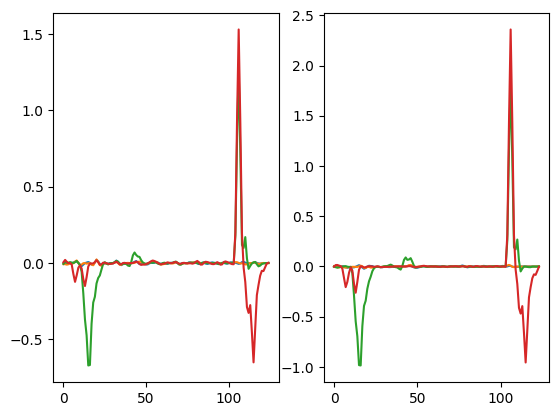

2


In [97]:
#with pd.option_context("display.max_rows", None): 
#    display(extra)
cnt = 1
for row in extra.iterrows():
    r = row[1]
    if r["uuid"]=="4e13f784-dc74-4532-b944-1789b3a95af1":
        cnt+=1
        sample = np.copy(data[r["uuid"]])
        sample[[0, 1]] = sample[[1, 0]]
        sample[[2, 3]] = sample[[3, 2]]
        score=similarity_score(sample, data[r["duplicate_for"]])
        #if score>VID_TRESHOLD:
        print(r["uuid"], r["duplicate_for"],score)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        for i in range(4):
            ax1.plot(data[r["uuid"]][i])
            ax2.plot(data[r["duplicate_for"]][i])
        plt.show()

print(cnt)

In [ ]:
import shutil

# Create a new folder to store the pairs of duplicate videos
pairs_folder = f'duplicate_pairs'
os.makedirs(pairs_folder, exist_ok=True)

# Iterate through each pair of duplicates in df_mini
for _, row in df_mini[df_mini["res"].isin(df_mini.uuid)].iterrows():
    original_uuid = row['res']
    duplicate_uuid = row['uuid']
    
    # Create a folder for each pair
    pair_folder = f'{pairs_folder}/{original_uuid}_{duplicate_uuid}'
    os.makedirs(pair_folder, exist_ok=True)
    
    # Define the source and destination paths for the original and duplicate videos
    original_video_path = f'{DATA_FOLDER}/{original_uuid}.mp4'
    duplicate_video_path = f'{DATA_FOLDER}/{duplicate_uuid}.mp4'
    
    # Copy the videos to the pair folder
    shutil.copy(original_video_path, f'{pair_folder}/{original_uuid}.mp4')
    shutil.copy(duplicate_video_path, f'{pair_folder}/{duplicate_uuid}.mp4')

In [ ]:
keys = list(data.keys())
similarity_scores(data[keys[54]], data)

{'00357913-2cad-4389-9bc6-a10c26f15679': inf,
 '0082f28a-16bb-4df7-9d74-7dd720d9547e': inf,
 '008e8b3a-8ee5-4ddf-b1ba-b8657541d5c2': inf,
 '00a7da80-6e83-46de-a2e4-aca87d4043ae': inf,
 '00c0e604-1581-4fbc-b365-1247e3393c26': inf,
 '00c74cb8-5863-4790-9640-eb3e3c23dc9a': inf,
 '01026d79-885d-49c5-b8a1-2bb9a603de4d': inf,
 '01037207-0047-4925-a585-f6bb8c511c90': inf,
 '013d4a72-1258-48e4-813e-ceba459ac5bd': inf,
 '015b841a-f904-4fdc-bc4f-39e8bda08c18': 1.1320114844142486,
 '017004ff-e8b9-4ce3-baad-4d29cfb487c4': inf,
 '01c23a9b-1431-4110-a073-82f78761cdf4': inf,
 '01d7830d-6f60-4bb3-8c85-8d8c91f38ba0': inf,
 '01ec6f48-b93b-4b70-b86a-b975e93797ac': inf,
 '021963d9-5ef2-476a-97d3-0c4b05113d08': inf,
 '022c98a5-ecbe-4504-b984-0539300c5779': inf,
 '0234d033-afb1-4ec4-add3-2fab9bf7914c': inf,
 '0243a61c-bb86-4aa1-b671-3d82811348eb': inf,
 '024cba15-750c-4d19-9b71-797ad095f647': inf,
 '024fef84-a06c-4b2a-ae5c-80983a842f17': inf,
 '02946cdf-31eb-48d1-8dec-960f47d75e9f': inf,
 '02e00046-ca4c-43a

In [ ]:
'''
for dir in tqdm(os.listdir("duplicate_pairs")):
    id1 = dir.split("_")
    id2 = id1[1]
    id1 = id1[0]
    vid1 = load("duplicate_pairs/"+dir+"/"+id1+".mp4")
    vid2 = load("duplicate_pairs/"+dir+"/"+id2+".mp4")
    print(id1, id2)
    if vid1.shape[0]-vid2.shape[0]>10:
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,3))
        embed1 = get_embed(vid1)
        embed2 = get_embed(vid2)

        e12 = embed1*embed1

        conv = np.convolve(embed1, np.flip(embed2), mode='valid')/np.sqrt(np.convolve(e12, np.ones(embed2.shape[0]), mode='valid'))

        ax1.plot(np.concatenate([conv, np.zeros(embed2.shape[0])]))
        shift = np.argmax(conv)
        print(shift)
        ax2.plot(embed1)
        ax2.plot(np.concatenate([np.zeros(shift), embed2]))
        plt.show()
        '''

'\nfor dir in tqdm(os.listdir("duplicate_pairs")):\n    id1 = dir.split("_")\n    id2 = id1[1]\n    id1 = id1[0]\n    vid1 = load("duplicate_pairs/"+dir+"/"+id1+".mp4")\n    vid2 = load("duplicate_pairs/"+dir+"/"+id2+".mp4")\n    print(id1, id2)\n    if vid1.shape[0]-vid2.shape[0]>10:\n        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,3))\n        embed1 = get_embed(vid1)\n        embed2 = get_embed(vid2)\n\n        e12 = embed1*embed1\n\n        conv = np.convolve(embed1, np.flip(embed2), mode=\'valid\')/np.sqrt(np.convolve(e12, np.ones(embed2.shape[0]), mode=\'valid\'))\n\n        ax1.plot(np.concatenate([conv, np.zeros(embed2.shape[0])]))\n        shift = np.argmax(conv)\n        print(shift)\n        ax2.plot(embed1)\n        ax2.plot(np.concatenate([np.zeros(shift), embed2]))\n        plt.show()\n        '